# Table of Contents
* [Load Packages and Data](#Load-Packages-and-Data)
* [Topic Modeling](#Topic-Modeling) 
    * [Build LDA Model with sklearn](#Build-LDA-Model-with-sklearn)
        * [Clean-up Review Text](#Clean-up-Review-Text)
        * [Create the Document-Word Matrix](#Create-the-Document-Word-Matrix)
        * [Try the 2-topic LDA Model](#Try-the-2-topic-LDA-Model)
        * [Find the Best LDA Model](#Find-the-Best-LDA-Model)
        * [Dominant Topic in each Document](#Dominant-Topic-in-each-Document)
        * [Visualize the LDA Model with pyLDAvis](#Visualize-the-LDA-Model-with-pyLDAvis)        
    * [Build LDA Model with Gensim](#Build-LDA-Model-with-Gensim)
        * [Create the Dictionary and Corpus Needed for Topic Modeling](#Create-the-Dictionary-and-Corpus-Needed-for-Topic-Modeling)
        * [Model Perplexity and Coherence Score](#Model-Perplexity-and-Coherence-Score)
        * [Visualize Topics with pyLDAvis](#Visualize-Topics-with-pyLDAvis)
        * [Test on Holdout data](#Test-on-Holdout-data)
* [Build Machine Learning Models for Prediction](#Build-Machine-Learning-Models-for-Prediction)
    * [Create a Target Column](#Create-a-Target-Column)
        * [t-test of the Character Length of Reviews](#t-test-of-the-Character-Length-of-Reviews)
    * [Build a Pipeline](#Build-a-Pipeline)
        * [Encoding the Categorical Target Feature](#Encoding-the-Categorical-Target-Feature)
    * [Use bag-of-word Features for Prediction](#Use-bag-of-word-Features-for-Prediction)
        * [Grid Search Hyperparameter](#Grid-Search-Hyperparameter)
        * [Strongly Predictive Features](#Strongly-Predictive-Features)
    * [Use Tfidf-weighted Features for Prediction](#Use-Tfidf-weighted-Features-for-Prediction)
        * [Feed Less TfidfVectorized Features to Classifier](#Feed-Less-TfidfVectorized-Features-to-Classifier)
    * [Use sklearn LDA Document Topics for Prediction](#Use-sklearn-LDA-Document-Topics-for-Prediction)
    * [Use Gensim LDA Document Topics for Prediction](#Use-Gensim-LDA-Document-Topics-for-Prediction)
    * [Compare Model Performance](#Compare-Model-Performance)

# Load Packages and Data 
This is the second part of the capstone project that investigates reviews dataset of hotels. It focuses on wrangling the text data and uses word features to train a machine learning classifier for hotel classification based on the review texts. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

#manipulate and view data in tabular format
import pandas as pd
import numpy as np
import pickle 
#process text
import re,nltk,spacy,gensim
from gensim.models import CoherenceModel
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

 #visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

#seaborn
import seaborn as sns
sns.set(context='paper',style='whitegrid',font_scale=2, rc={"lines.linewidth": 2.5})#style=whitegrid,darkgrid,white,dark
pd.set_option('display.max_columns', None)


#LDA visualzation
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim




#sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint #Data pretty printer
from sklearn.feature_selection import SelectKBest,chi2




We've cleaned the raw hotel data as reported in the [milestone report](https://github.com/phyhouhou/SpringboardProjects/blob/master/SecondCapstoneProject/2ndCapstoneProject_MilestoneReport/2ndCapstoneProject_Milestone.ipynb) by handling missing values, drop duplilcates and cleaning and enriching features. Here we load the cleaned hotel data for analysis and focus on the review texts.

In [3]:
data=pd.read_csv('data/htl_clean.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515212 entries, 0 to 515211
Data columns (total 24 columns):
Review_Date                                   515212 non-null object
Review_Month                                  515212 non-null object
Review_Wday                                   515212 non-null object
Hotel_Name                                    515212 non-null object
Hotel_Address                                 515212 non-null object
Hotel_City                                    515212 non-null object
lat                                           511944 non-null float64
lng                                           511944 non-null float64
Average_Score                                 515212 non-null float64
Total_Number_of_Reviews                       515212 non-null int64
Reviewer_Nationality                          515212 non-null object
Total_Number_of_Reviews_Reviewer_Has_Given    515212 non-null int64
Reviewer_Score                                515212 non-nul

,Review_Date,Review_Month,Review_Wday,Hotel_Name,Hotel_Address,Hotel_City,lat,lng,Average_Score,Total_Number_of_Reviews,Reviewer_Nationality,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Negative_Review,Review_Total_Negative_Word_Counts,Neg_Rev_WCRatio,Positive_Review,Review_Total_Positive_Word_Counts,Pos_Rev_WCRatio,Trip_Type,Traveler_Type,Num_Nights,Additional_Number_of_Scoring,days_since_review
0,2017-08-03,Aug,Thu,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Russia,7,2.9,I am so angry that i made this post available...,397,0.973039,Only the park outside of the hotel was beauti...,11,0.026961,Leisure trip,Couple,6.0,194,0
1,2017-08-03,Aug,Thu,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Ireland,7,7.5,No Negative,0,0.000000,No real complaints the hotel was great great ...,105,1.000000,Leisure trip,Couple,4.0,194,0
2,2017-07-31,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Australia,9,7.1,Rooms are nice but for elderly a bit difficul...,42,0.666667,Location was good and staff were ok It is cut...,21,0.333333,Leisure trip,Family with young children,3.0,194,3
3,2017-07-31,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,United Kingdom,1,3.8,My room was dirty and I was afraid to walk ba...,210,0.889831,Great location in nice surroundings the bar a...,26,0.110169,Leisure trip,Solo traveler,3.0,194,3
4,2017-07-24,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,New Zealand,3,6.7,You When I booked with your company on line y...,140,0.945946,Amazing location and building Romantic setting,8,0.054054,Leisure trip,Couple,2.0,194,10


# Topic Modeling 

## Build LDA Model with sklearn
The aim  of topic modeling is to extract hidden topics from a large volume of texts and LDA is a popular algorithm for topic modeling. In this section, we will first clean the texts and then create a word-document matrix, which is a required input for implementing the LDA algorithm with sklearn. We will then build a LDA model and discuss the model performance to find out what topics reviewers are talking about. 

### Clean-up Review Text 

Review texts will be processed in the following steps:

* Remove short reviews
* Remove all non-letters characters;
* Strip whitespaces;
* Tokenize sentence into a list of words;
* Remove English stopwords;
* Lemmatize words to its roots.

Then we will save the cleaned review texts in a csv file for future analysis.

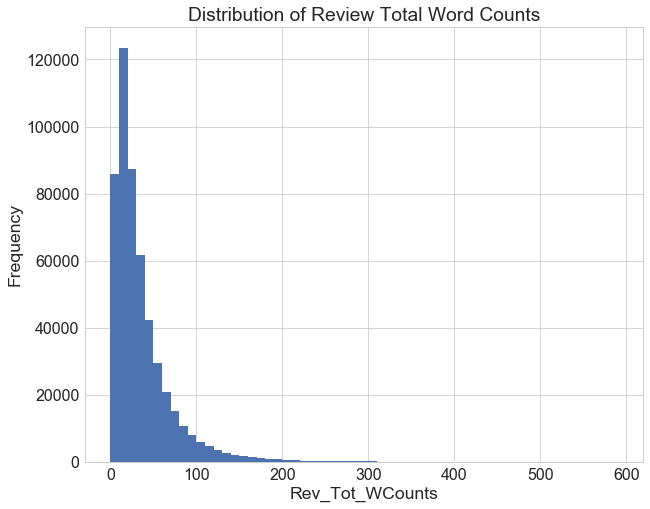

In [4]:
Rev_Tot_WCounts=data['Review_Total_Positive_Word_Counts']+data['Review_Total_Negative_Word_Counts']

plt.hist(Rev_Tot_WCounts,bins=np.arange(0,600,10))
plt.xlabel('Rev_Tot_WCounts')
plt.ylabel('Frequency')
plt.title('Distribution of Review Total Word Counts');



In [5]:
# Set for the total word count of a review a threshold below which reviews will be removed 
thresh=10
idx=Rev_Tot_WCounts<thresh
#len(data[idx])/len(data), len(data[~idx])


# Reorganize columns
categories=['Review_Month','Hotel_City','Reviewer_Nationality','Trip_Type','Traveler_Type']
numerics=['Total_Number_of_Reviews_Reviewer_Has_Given','Review_Total_Positive_Word_Counts','Review_Total_Negative_Word_Counts','Num_Nights']
text=['Negative_Review','Positive_Review']
cols=categories+text+['Reviewer_Score']
df=data[~idx][cols]


df.Negative_Review.replace('No Negative', ' ',inplace=True)
df.Positive_Review.replace('No Positive', ' ',inplace=True)

# Combine positive and negative reviews
Full_Review=df.Negative_Review+' '+df.Positive_Review
for num,message in enumerate(Full_Review.sample(5, random_state=100)):
    print(num,message)
    print ('\n')


0  The breakfast is too simple The lift is the smallest one I have seen  The location is really convenient beside the park The staff is helpful 


1  Quite could be a little bit less price wise for 1 night  Area room


2  Too hot room air conditioner not working couldn t open window as outside air conditioning units very loud dark room  Great restaurant comfy beds great location


3  No room for smokers room did not have a balcony  


4  The air condition could have been better One member of the desk staff was not the best to deal with   Very comfortable bed Always clean and dry towels Friendly staff 




In [5]:
# Caution: very time-consuming. We've saved the lemmatized reviews in a csv file


#---------Prepare the review text column--------
def prepare_txt(txts): #txts=df[txt_col]
    # Convert reviews to a list
    texts=txts.values.tolist()
    
    # Remove non-letter characters
    texts=[re.sub('[^a-zA-Z]',' ', t) for t in texts]
    
    # Strip whitespaces
    texts=[t.strip() for t in texts]
    
    return texts
   
#----------Remove Stopwords-----------------   
#Prepare NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hotel'])

# Tokenize and Remove stopwords
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


#-----------Lemmatization------------------
import warnings
warnings.filterwarnings('ignore')

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation. All pronouns are lemmatized to the special token -PRON-"""
    texts_lemma = []
    for w in texts:
        doc = nlp(' '.join(w)) 
        texts_lemma.append(' '.join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_lemma


# Do lemmatization keeping only Noun, Adj, Verb, Adverb
neg_reviews=remove_stopwords(prepare_txt(df['Negative_Review']))
pos_reviews=remove_stopwords(prepare_txt(df['Positive_Review']))


neg_rev_lemmatized = lemmatization(neg_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
pos_rev_lemmatized = lemmatization(pos_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



# Save the lemmatized reviews
df['Neg_Rev_Lemmatized']=neg_rev_lemmatized
df['Pos_Rev_Lemmatized']=pos_rev_lemmatized


df.to_csv('data/htl_rev_lem_added.csv',index=False) 

**Load Cleaned Data**

In [6]:
#Load cleaned data
df_txt=pd.read_csv('data/htl_rev_lem_added.csv')

# Join negative and positive reviews
df_txt['Rev_Lemmatized']=df_txt['Neg_Rev_Lemmatized'].fillna('')+' '+df_txt['Pos_Rev_Lemmatized'].fillna('')

df_txt.head()

,Review_Month,Hotel_City,Reviewer_Nationality,Trip_Type,Traveler_Type,Negative_Review,Positive_Review,Reviewer_Score,Neg_Rev_Lemmatized,Pos_Rev_Lemmatized,Rev_Lemmatized
0,Aug,Amsterdam,Russia,Leisure trip,Couple,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,angry make post available possible site use pl...,park beautiful,angry make post available possible site use pl...
1,Aug,Amsterdam,Ireland,Leisure trip,Couple,,No real complaints the hotel was great great ...,7.5,NaN,real complaint great great location surroundin...,real complaint great great location surroundi...
2,Jul,Amsterdam,Australia,Leisure trip,Family with young children,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,room nice elderly bit difficult room story nar...,location good staff cute breakfast range nice ...,room nice elderly bit difficult room story nar...
3,Jul,Amsterdam,United Kingdom,Leisure trip,Solo traveler,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,3.8,room dirty afraid walk barefoot floor look cle...,great location nice surrounding bar restaurant...,room dirty afraid walk barefoot floor look cle...
4,Jul,Amsterdam,New Zealand,Leisure trip,Couple,You When I booked with your company on line y...,Amazing location and building Romantic setting,6.7,book company line show picture room think get ...,amazing location build romantic setting,book company line show picture room think get ...


In [9]:
print('Number of non-null Negative_Review: %d' %len(df_txt.Neg_Rev_Lemmatized.dropna()))
print('Number of non-null Positive_Review: %d' %len(df_txt.Pos_Rev_Lemmatized.dropna()))
print('Number of Observations: %d' %len(df_txt))

Number of non-null Negative_Review: 343488
Number of non-null Positive_Review: 405189
Number of Observations: 429464


### Create the Document-Word Matrix 
We create the document-word matrix by using CountVectorizer as the main input of the LDA topic model. Since the review data is very large, we only consider words that has occurred at at least 10 times (min_df) and with at least character length 3 , remove built-in english stopwords and convert all words to lowercase.

In [35]:
# Joined negative and positive reviews
rev_lemmatized=df_txt['Rev_Lemmatized']

# Initialise the CountVectorizer with the required configuration
c_vec = CountVectorizer(analyzer='word',       
                             min_df=10,                       
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',    # num chars > 3 
                             #max_features=10000             # max number of unique words
                            )

# Build the vocabulary by 'fit'
c_vec.fit(rev_lemmatized)

# Convert reviews to a bag of words
rev_vectorized=c_vec.transform(rev_lemmatized) 

In [11]:
# Check the sparscity, i.e., percentage of Non-Zero cells
print ('Shape of Sparse Matrix: ', rev_vectorized.shape)
print ('Amount of Non-Zero occurences: ', rev_vectorized.nnz)
print ('sparsity: %.2f%%' % (100.0 * rev_vectorized.nnz / (rev_vectorized.shape[0] * rev_vectorized.shape[1])))

Shape of Sparse Matrix:  (429464, 10670)
Amount of Non-Zero occurences:  6941938
sparsity: 0.15%


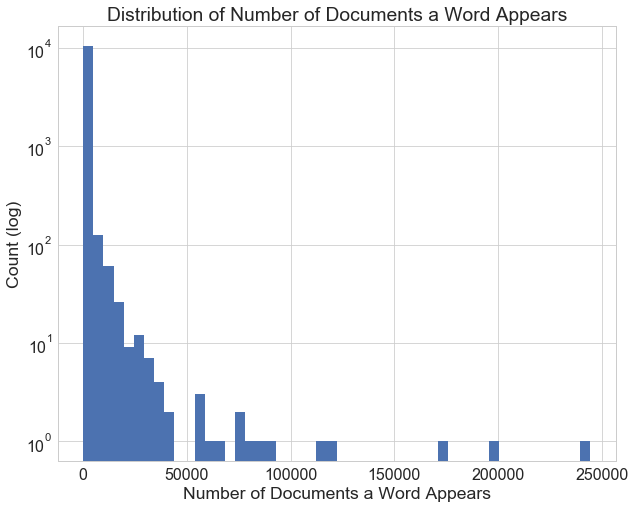

In [12]:
#Calculate 'count' as the number of documents that a word appears 
count=(rev_vectorized>0).sum(axis=0).A.tolist()[0]#count as 1 if the word appear in a document regardless how many times it appear
plt.hist(count,bins=50,log=True)
plt.xlabel('Number of Documents a Word Appears')
plt.ylabel('Count (log)')
plt.title('Distribution of Number of Documents a Word Appears');

The distribution is very long-tailed. Some of the words appear in too many documents.

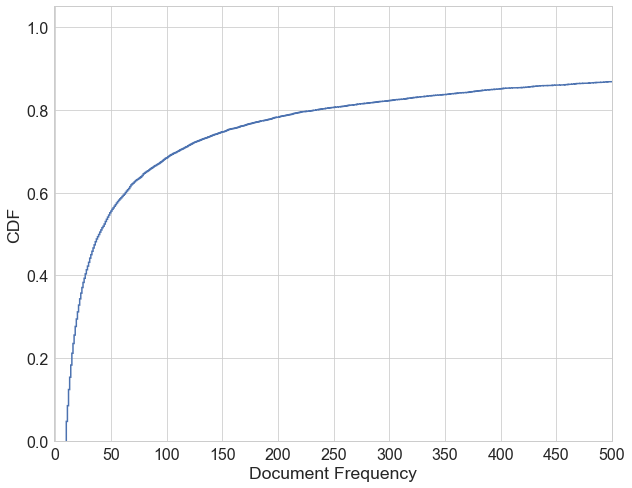

In [13]:
#Construct the cumulative distribution of document frequencies (df)
plt.hist(count,bins=np.unique(count),cumulative=True,density=True,histtype='step',linewidth=1.5);
plt.xlabel('Document Frequency')
plt.ylabel('CDF')
plt.xticks(np.arange(0,501,50))
plt.xlim(-1,500);



This CDF plot justified us in setting 'min_df'=10 around which the curve starts to climb steeply.

In [14]:
# Word feature in each column of the transformed matrix
wfeatures=c_vec.get_feature_names()
print("Lengh of features:",len(wfeatures))

Lengh of features: 10670


In [15]:
# Word and its count
d=dict(zip(wfeatures, np.ravel(rev_vectorized.sum(axis=0))))
print('\n Top 10 Features in the bag-of-word and the counts:\n')
pd.DataFrame(sorted(d.items(),key=lambda x: x[1],reverse=True)[:10],columns=['word','count'])


 Top 10 Features in the bag-of-word and the counts:



,word,count
0,room,376243
1,staff,218196
2,location,178012
3,good,145318
4,breakfast,135939
5,great,106319
6,bed,97308
7,friendly,83682
8,clean,81072
9,helpful,76320


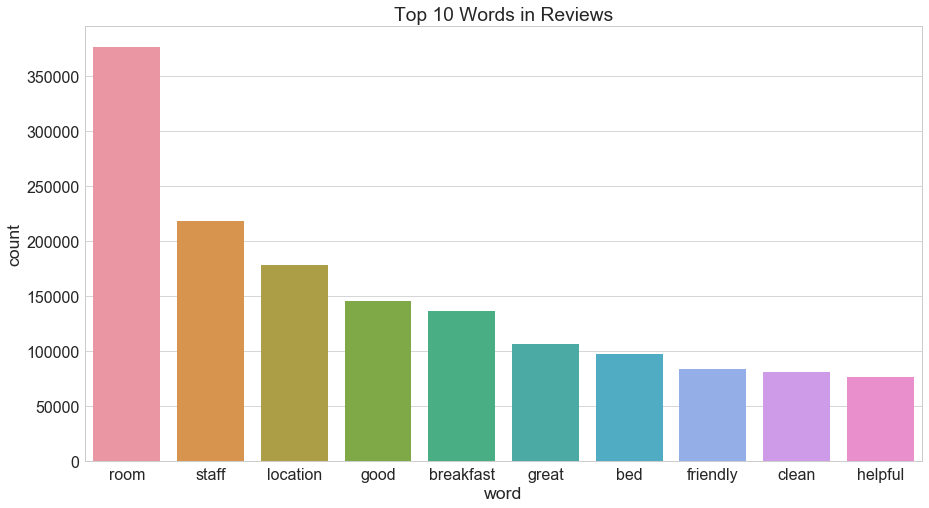

In [17]:
# Visualize counts of words
d=dict(zip(wfeatures, np.ravel(rev_vectorized.sum(axis=0))))
w_c=pd.DataFrame.from_dict((d),orient='index').reset_index()
w_c.columns=('word','count')
w_c=w_c.sort_values(by='count',ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(x='word', y='count', data=w_c.head(10).sort_values('count',ascending=False))            
plt.title("Top 10 Words in Reviews");

### Try the 2-topic LDA Model 

The reviews have both negative and positive part. Will the model be able to separate reviews into positive and negative ones? Since topic-modeling can be quite time-consuming, let's build a 2-topic model to investigate this issue. 

In [19]:
lda_modeln2 = LDA(n_components=2,          
                  max_iter=10, # default max learning iterations: 10 too slow
                  learning_method='online',   
                  random_state=100,          # Random state
                  batch_size=128,            # default num docs in each learning iter
                  evaluate_every = 0,       # compute perplexity every n iters, default: Don't
                  n_jobs = -1,               # Use all available CPUs
                  )
lda_modeln2.fit(rev_vectorized)
lda_output = lda_modeln2.transform(rev_vectorized)

lda_n2_LogLikelihood=lda_modeln2.score(rev_vectorized)
lda_n2_perp=lda_modeln2.perplexity(rev_vectorized)

In [25]:
# See model parameters
print('Model parameters:')
pprint(lda_modeln2.get_params())

#----Diagnose model performance with perplexity and log-likelihood---
# Log Likelyhood: Higher the better
print("\nLog Likelihood Score: %.2f" %lda_n2_LogLikelihood) 

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("\nPerplexity: %.2f" %lda_n2_perp) 



Model parameters:
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': 0,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 2,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

Log Likelihood Score: -49818647.92

Perplexity: 703.15


In [27]:
# Define a function to display topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 20
feature_names=c_vec.get_feature_names()
display_topics(lda_modeln2, feature_names, num_top_words)

Topic 0:
room bed night staff good shower check breakfast bathroom day location time small work reception book stay make floor ask
Topic 1:
staff room location good breakfast great friendly helpful nice clean excellent comfortable stay bed close restaurant station walk really lovely


Topics are quite overlapped for n_component=2 model and the model doesn't seem to classify reviews as negative and positive topics as expected. 

### Find the Best LDA Model 
We feed the bag of words to LDA model to group words into topics. We find the best LDA model by gridsearching the most important parameter, i.e., the number of topics in the model. Since we have limited computing resources, we will focus on tuning the most important parameter for LDA models, i.e., n_components (number of topics).

In [93]:
# Take several hours
import warnings
warnings.filterwarnings('ignore')


# Define Search Param
search_params = {'n_components': [5, 10]}

# Init the Model
lda = LDA(n_jobs=1,random_state=100)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params) 

# Do the Grid Search
model.fit(rev_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [5, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [94]:
# Show the best topic model and its parameters

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: %.2f" %(model.best_score_))

# Perplexity
print("Model Perplexity: %.2f" %( best_lda_model.perplexity(rev_vectorized)))


Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -17358897.097666238
Model Perplexity:  721.0095694542667


So n_components=5 outperforms n_components=10. We will set n_components=5 in the following LDA models. The 2-topic model has a higher score (higher Log Likelihood and lower Perplexity score) compared to that of 5-topic model 

**Save the best_lda_model**

Since it's quite time-consuming to train the LDA model, we save the model in the disk.

In [ ]:
# # Save model using pickle
filename = 'best_lda.sav'
pickle.dump(best_lda_model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
best_lda_model = pickle.load(open(filename, 'rb'))

### Dominant Topic in each Document

What particular topic does a document belong to? A dominant topic in a document is spotted by finding the topic that has the highest contributions (revealed by the document-topic matrix) to that document. We will first display top 20 keywords in all the topics and then make a table to show all major topics in a document and specify the most dominant topic in that document.

#### Display keywords in topics

In [16]:
num_top_words = 20
feature_names=c_vec.get_feature_names()
print('Top 20 Words in topics found in the best_lda_model')
display_topics(best_lda_model , feature_names, num_top_words)

Top 20 Words in topics found in the best_lda_model
Topic 0:
room bed bathroom small location good shower clean comfortable nice floor window work size air noise night noisy water door
Topic 1:
room check time stay day night book ask pay staff reception parking make train say charge leave come tell service
Topic 2:
staff location friendly helpful room great excellent breakfast good clean stay comfortable nice bed lovely service perfect really amazing fantastic
Topic 3:
breakfast bar restaurant room coffee food view tea good area service great drink free distance excellent lovely choice facility provide
Topic 4:
good location close room station walk breakfast price nice great city clean metro wifi pool minute easy area restaurant value


Topic 0 mentioned 'room', 'location', small', 'noise' etc. This topic appears to contain typical negative features.<br>
Topic 1 focuses on staff, reception service.<br>
Topic 2 talks about positive aspects of staff, location, room, breakfast, bed etc.<br>
Topic 3 focuses on food and drinks ('restaurant', 'bar').<br>
Topic 4 is quite general, similar to topic 2 but with addition reviews on price, wifi, poor etc.<br>

#### Make a  Document - Topic Table 

In [17]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(rev_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_txt))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topics = df_document_topic.head(10)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.21,0.43,0,0.14,0.22,1
Doc1,0,0.24,0.15,0,0.59,4
Doc2,0.39,0.4,0.01,0.2,0.01,1
Doc3,0.49,0.25,0,0.03,0.22,0
Doc4,0,0.75,0.17,0.03,0.05,1
Doc5,0.06,0.1,0.01,0.47,0.36,3
Doc6,0.62,0.16,0.2,0.01,0.01,0
Doc7,0.14,0.01,0.25,0.35,0.25,3
Doc8,0.36,0.32,0.02,0.18,0.11,0
Doc9,0.52,0.01,0.01,0.25,0.21,0


#### Visualize topics distribution across documents

In [18]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num_Documents")
df_topic_distribution.columns = ['Topic', 'Num_Documents']
df_topic_distribution


,Topic,Num_Documents
0,2,156731
1,0,131552
2,4,101595
3,1,70962
4,3,54372


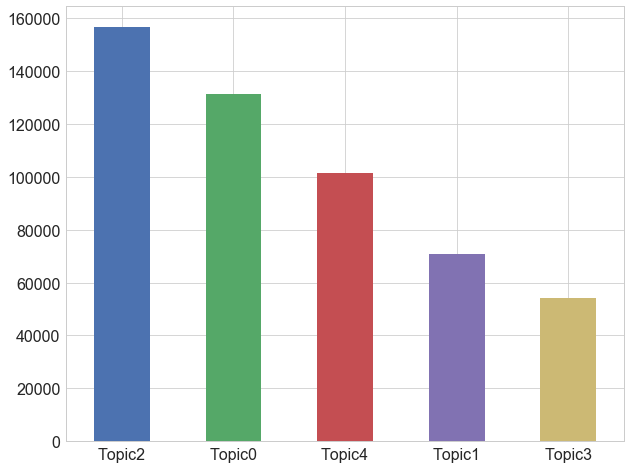

In [19]:
# Visualize the topic distributions across documents
df_topic_distribution['Num_Documents'].plot(kind='bar',rot=0)
plt.xticks(np.arange(0,5),'Topic'+df_topic_distribution['Topic'].astype('str'));

### Visualize the LDA Model with pyLDAvis 

In [23]:
pyLDAvis.enable_notebook()
lda_display_sk= pyLDAvis.sklearn.prepare(best_lda_model, rev_vectorized, c_vec, mds='tsne')
lda_display_sk

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      21.700312        1       1   -6.750979  -46.153248
4      21.445093        1       2   64.309280 -106.989586
1      20.865534        1       3   64.664154   19.154392
2      20.364604        1       4  151.232605  -15.570311
3      15.624457        1       5  157.712555 -112.127487, topic_info=      Category           Freq        Term          Total  loglift  logprob
term                                                                      
9040   Default  231180.000000       staff  231180.000000  30.0000  30.0000
3941   Default   87917.000000    friendly   87917.000000  29.0000  29.0000
4498   Default   79589.000000     helpful   79589.000000  28.0000  28.0000
5548   Default  200456.000000    location  200456.000000  27.0000  27.0000
853    Default  101399.000000         bed  101399.000000  26.0000  26.0000
747    Default   43617.000000         bar   43617.000000  25.0000  25.0000
1153   Default  154566.000000   breakfast  154566.000000  24.0000  24.0000
804    Default   46887.000000    bathroom   46887.000000  23.0000  23.0000
8136   Default  384604.000000        room  384604.000000  22.0000  22.0000
4260   Default  114738.000000       great  114738.000000  21.0000  21.0000
1794   Default   41269.000000       close   41269.000000  20.0000  20.0000
8752   Default   57184.000000       small   57184.000000  19.0000  19.0000
9096   Default   36916.000000     station   36916.000000  18.0000  18.0000
10503  Default   36328.000000        walk   36328.000000  17.0000  17.0000
8592   Default   35385.000000      shower   35385.000000  16.0000  16.0000
1597   Default   34014.000000       check   34014.000000  15.0000  15.0000
3407   Default   64333.000000   excellent   64333.000000  14.0000  14.0000
9101   Default   67747.000000        stay   67747.000000  13.0000  13.0000
4181   Default  156784.000000        good  156784.000000  12.0000  12.0000
7969   Default   39329.000000  restaurant   39329.000000  11.0000  11.0000
1845   Default   23868.000000      coffee   23868.000000  10.0000  10.0000
7342   Default   28829.000000       price   28829.000000   9.0000   9.0000
1740   Default   87092.000000       clean   87092.000000   8.0000   8.0000
9708   Default   36071.000000        time   36071.000000   7.0000   7.0000
1700   Default   26296.000000        city   26296.000000   6.0000   6.0000
3824   Default   29642.000000        food   29642.000000   5.0000   5.0000
2486   Default   34050.000000         day   34050.000000   4.0000   4.0000
1057   Default   23827.000000        book   23827.000000   3.0000   3.0000
6381   Default   40295.000000       night   40295.000000   2.0000   2.0000
5618   Default   34252.000000      lovely   34252.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
3133    Topic5    5072.778084         egg    5073.579059   1.8562  -5.4889
8132    Topic5    4918.740507     rooftop    4919.547200   1.8562  -5.5197
3534    Topic5    4875.145469    fabulous    4875.954074   1.8562  -5.5286
5928    Topic5    4537.109295        menu    4537.912197   1.8562  -5.6005
5885    Topic5    3997.210544        meal    3998.014139   1.8561  -5.7272
3968    Topic5    3886.373876       fruit    3887.176339   1.8561  -5.7553
4039    Topic5    3474.794944      garden    3475.601136   1.8561  -5.8673
9815    Topic5    3263.257010       tower    3264.057711   1.8561  -5.9301
5468    Topic5    3134.105335     limited    3134.913523   1.8561  -5.9705
8468    Topic5    5916.097145       serve    5918.633153   1.8559  -5.3351
2747    Topic5    6040.138866      dinner    6058.141129   1.8534  -5.3144
3824    Topic5   23211.697359        food   29642.434624   1.6118  -3.9681
1655    Topic5   11089.911646      choice   13644.883805   1.6490  -4.7068
7969    Topic5   24881.096502  restaurant   39329.152527   1.3985  -3.8987
1153    Topic5   64775.131

## Build LDA Model with Gensim
Since the LDA model with sklearn takes lots of computing resources for larger number of topics. We turn to gensim for building the LDA model. For gensim we need to tokenize the data and filter out stopwords. 

### Create the Dictionary and Corpus Needed for Topic Modeling
Since the size of reviews is quite large, we randomly select some samples to train the model. We can evaluate our topic models by the holdout test set.

In [36]:
from sklearn.model_selection import train_test_split

# small samples for test
#dft=df_txt.sample(50,random_state=100)
#itrain, itest = train_test_split(range(dft.shape[0]), train_size=0.7,random_state=100)
#mask = np.zeros(dft.shape[0], dtype=np.bool)
#mask[itrain] = True
#rev_gens=dft['Rev_Lemmatized'][mask]

itrain, itest = train_test_split(range(df_txt.shape[0]), train_size=0.7,random_state=100)
mask = np.zeros(df_txt.shape[0], dtype=np.bool)
mask[itrain] = True

rev_gens=df_txt['Rev_Lemmatized'][mask]

In [41]:
#Prepare NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hotel'])



# Tokenize and clean sentences to words 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations



def process_text(sentences):
    # Create Corpus
    txt_tokenized=list(sent_to_words(sentences))
    # Remove stopwords
    txt_tokenized = [[w for w in doc if w not in stop_words] for doc in txt_tokenized]
    return txt_tokenized


import warnings
warnings.filterwarnings('ignore')



def build_lda(revs,ntopics,passes=15):
    """Tokenize and clean reviews by process_text, then create dictionary and corpus and build LDA model"""
    rev_tokenized=process_text(revs)
    # Create Dictionary-association word to numericID
    dictionary = gensim.corpora.Dictionary(rev_tokenized )
    # Term Document Frequency-transform collections of texts to numeric form
    corpus = [dictionary.doc2bow(txt) for txt in rev_tokenized ]

    # #View the first document:[(word_id,count ),()...]
    # print(corpus[:1])


    #save dictionary and corpus
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')

    #build lda model
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics = ntopics, id2word=dictionary, passes=15,random_state=100)
    #ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics =ntopics, id2word=dictionary, passes=15,random_state=100) #Multicore very demanding on memory; can do for ntopics=10 but not 50 +
    
    #save ldamodel
    ldamodel.save('model{0}.gensim'.format(ntopics))
    topics = ldamodel.print_topics(num_words=10)
    for topic in topics:
        print('Topics:\n',topic)
    
    print('num_topic: %d' %ntopics)
    
    # Compute Perplexity
    log_perplexity=ldamodel.log_perplexity(corpus)
    print('\nPerplexity: %.2f' %(log_perplexity))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_ldamodel= CoherenceModel(model=ldamodel, texts=rev_tokenized, dictionary=dictionary, coherence='c_v')
    coherence= coherence_ldamodel.get_coherence()
    print('\nCoherence Score: %.2f' %coherence)
    
    return ntopics,log_perplexity,coherence
ntopics=5
_=build_lda(rev_gens,ntopics=ntopics,passes=15)

Topics:
 (0, '0.070*"breakfast" + 0.061*"room" + 0.061*"staff" + 0.049*"good" + 0.043*"location" + 0.028*"friendly" + 0.027*"great" + 0.026*"clean" + 0.023*"helpful" + 0.022*"nice"')
Topics:
 (1, '0.030*"room" + 0.016*"check" + 0.015*"get" + 0.014*"day" + 0.012*"time" + 0.011*"ask" + 0.011*"pay" + 0.011*"book" + 0.010*"night" + 0.010*"reception"')
Topics:
 (2, '0.049*"staff" + 0.040*"stay" + 0.019*"would" + 0.018*"helpful" + 0.018*"great" + 0.015*"friendly" + 0.015*"nothing" + 0.014*"location" + 0.013*"room" + 0.013*"everything"')
Topics:
 (3, '0.036*"close" + 0.034*"station" + 0.030*"walk" + 0.027*"location" + 0.023*"metro" + 0.022*"city" + 0.019*"good" + 0.015*"minute" + 0.013*"easy" + 0.013*"train"')
Topics:
 (4, '0.090*"room" + 0.032*"bed" + 0.020*"bathroom" + 0.020*"small" + 0.019*"location" + 0.017*"shower" + 0.015*"good" + 0.012*"floor" + 0.011*"clean" + 0.011*"nice"')
num_topic: 5

Perplexity: -6.84

Coherence Score: 0.58


### Model Perplexity and Coherence Score 
Investigate the model performance by the figure below:
ntopic v.s. coherence

In [42]:
ntopics=5

### Visualize Topics with pyLDAvis
Pick the optimal model and visualize and interpret topics with pyLDAvis.

In [45]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_gensim = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
lda_display = pyLDAvis.gensim.prepare(lda_gensim, corpus, dictionary, sort_topics=False)

# Save the visualization in a html format
pyLDAvis.save_html(lda_display, 'gensimldan{0}.html'.format(ntopics))

# Interactive visualization
pyLDAvis.display(lda_display)

### Test on Holdout data

In [48]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))
#lda_gensim = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))



new_doc=df_txt['Rev_Lemmatized'][~mask].sample(1,random_state=100)
doc_tokenized=process_text(new_doc)
doc_bow=[dictionary.doc2bow(d) for d in doc_tokenized]
dtm=lda_gensim.get_document_topics(doc_bow)

print(new_doc.values)


for t in dtm:
    print(t)


['make room reservation booking pay room separate make huge mess charge time confuse key room reservation name room location good']
[(1, 0.5957945203838086), (2, 0.10343257692519915), (4, 0.28128821887367367)]


# Build Machine Learning Models for Prediction 
Since we focus on the review texts in this part, we build machine learning models using features generated from texts. Before that we need to create our target variable 'label'. Since a reviewer's score ranges from 0 to 10, for simplicity, we classify a hotel as 'poor' if the score is below 7.1 and 'good' if it's between 7.1 and 9.5 otherwise 'excellent'.

## Create a Target Column

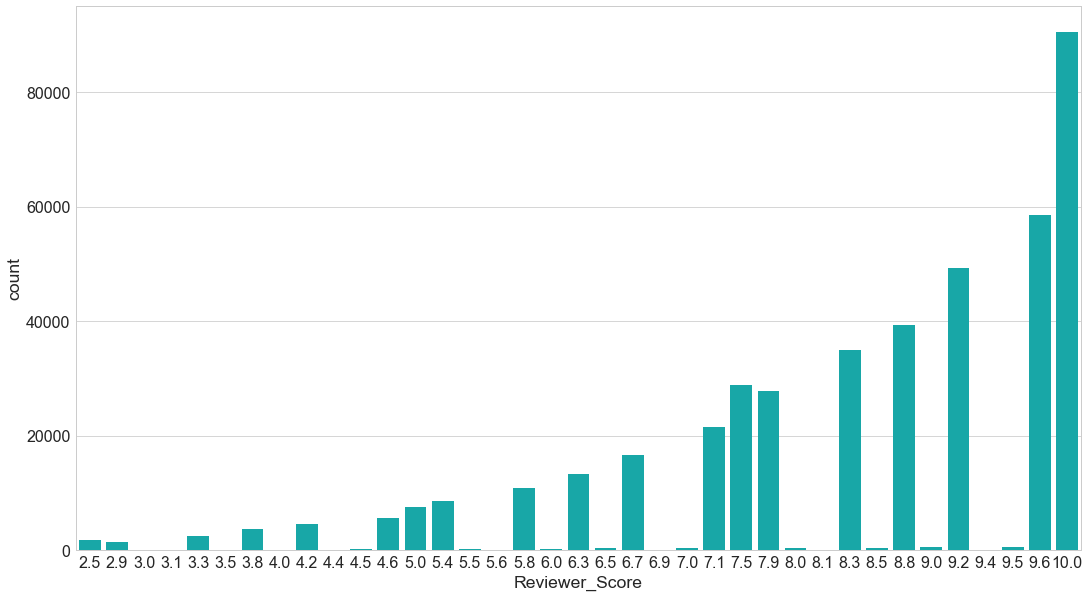

In [49]:
# Visualize the reviewer score
plt.figure(figsize=(18,10))
sns.countplot(df_txt.Reviewer_Score,color='c');

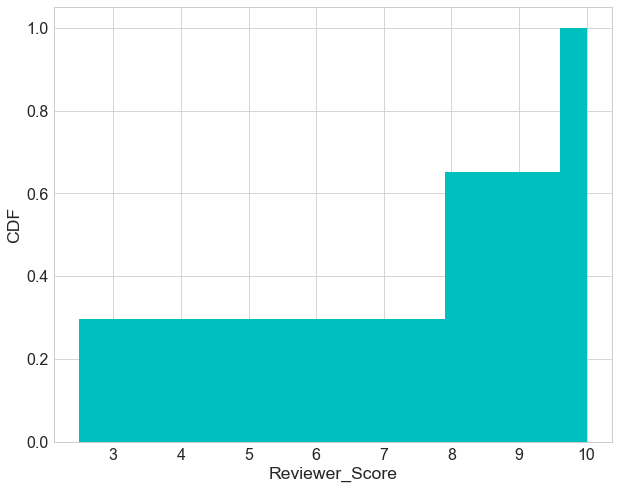

In [50]:
# Split Reviewe_Score into 3 buckets by quantiles
#pd.qcut(df_txt.Reviewer_Score,3).cat.categories
bins=[2.5, 7.9, 9.6, 10.0]
df_txt.Reviewer_Score.plot(kind='hist', cumulative=True,histtype='bar',normed=True,bins=bins,color='c')
plt.xlabel('Reviewer_Score')
plt.ylabel('CDF');

In [51]:
#Add 'label' by converting 'continuous' Reviewer_Score into 3 categories
df_txt['label']=pd.qcut(df_txt.Reviewer_Score,3,labels=['Poor','Good','Excellent'])

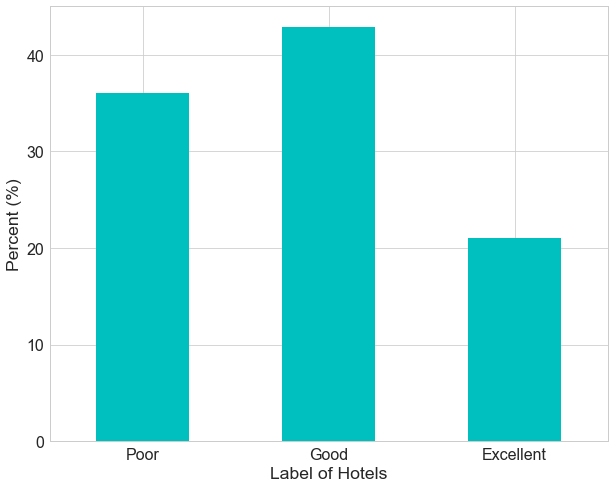

In [31]:
(df_txt.label.value_counts(normalize=True).sort_index()*100).plot(kind='bar',color='c',rot=0,figsize=(10,8));
plt.ylabel('Percent (%)')
plt.xlabel('Label of Hotels');

In [52]:
df_txt.drop('Reviewer_Score',axis=1).groupby('label').describe()

Hotel_City                       Neg_Rev_Lemmatized          \
               count unique     top   freq              count  unique   
label                                                                   
Poor          154949      6  London  84868             148202  142182   
Good          184068      6  London  89666             144192  122609   
Excellent      90447      6  London  44921              51094   31824   

                         Negative_Review                     \
               top  freq           count  unique top   freq   
label                                                         
Poor       nothing   498          154949  146047       6431   
Good       nothing  5770          184068  131420      38974   
Excellent  nothing  9312           90447   36354      38138   

          Pos_Rev_Lemmatized                           Positive_Review  \
                       count  unique         top  freq           count   
label                                                                    
Poor                  136610  101312    location  7260          154949   
Good                  179157  165756    location   843          184068   
Excellent              89422   87059  everything   223           90447   

                             Rev_Lemmatized          \
           unique top   freq          count  unique   
label                                                 
Poor       113815      18185         154949  154844   
Good       173286       4840         184068  183901   
Excellent   88636        987          90447   90335   

                                                                   \
                                                         top freq   
label                                                               
Poor                               room small location great    5   
Good                                  staff friendly helpful   13   
Excellent   room spacious nicely arrange separate busines...    8   

          Review_Month                    Reviewer_Nationality         \
                 count unique  top   freq                count unique   
label                                                                   
Poor            154949     12  Jul  15462               154949    206   
Good            184068     12  Aug  18022               184068    206   
Excellent        90447     12  Aug   9141                90447    179   

                                   Traveler_Type                        \
                        top   freq         count unique     top   freq   
label                                                                    
Poor        United Kingdom   71781        154949      6  Couple  70738   
Good        United Kingdom   88058        184068      6  Couple  93284   
Excellent   United Kingdom   48595         90447      6  Couple  48925   

          Trip_Type                               
              count unique           top    freq  
label                                             
Poor         149850      2  Leisure trip  118401  
Good         179392      2  Leisure trip  153483  
Excellent     88273      2  Leisure trip   78898

In [53]:
# Lenghth of characters in a full-review
df_txt['Len_LemRev_char']=df_txt['Rev_Lemmatized'].apply(len)


Correlation: -0.12


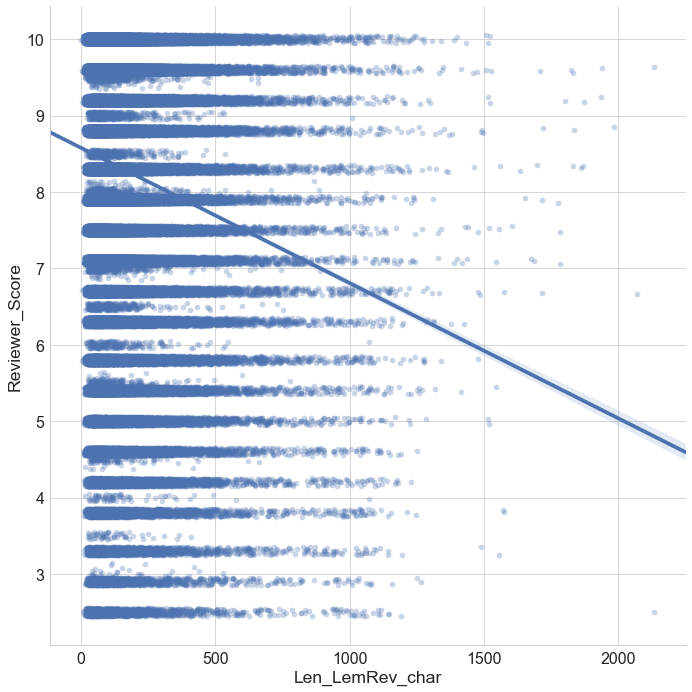

In [54]:
# How is the length of lemmatized clean reviews related with the reviewer score
sns.lmplot(y='Reviewer_Score',x='Len_LemRev_char',data=df_txt,y_jitter=0.05,size=10,scatter_kws={'alpha':0.3});
print('Correlation: %.2f'%(df_txt.Len_LemRev_char.corr(df_txt.Reviewer_Score)))

The above figure indicates that the longer the character length of a review the lower the score tends to be.

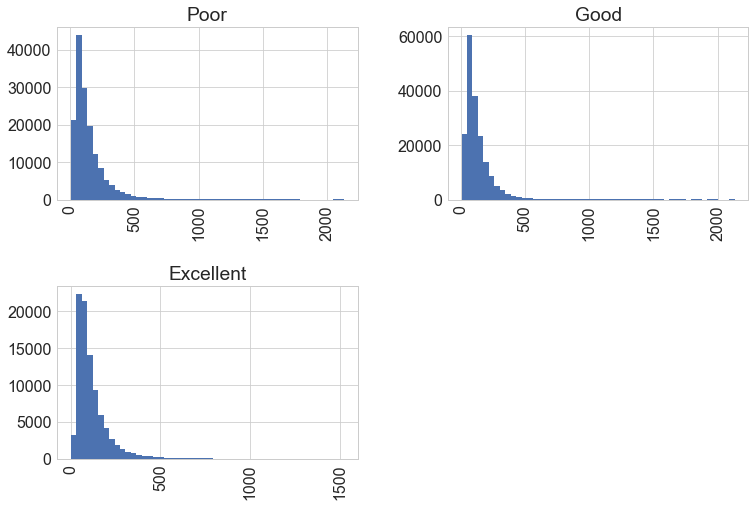

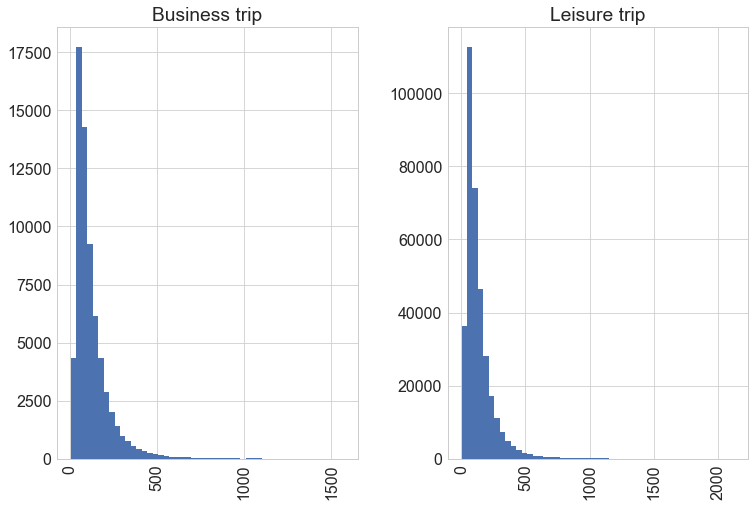

In [55]:
# Visualize the distribution of length of review strings by hotel label
df_txt.hist(column='Len_LemRev_char',by='label',bins=50,figsize=(12,8))
plt.xlabel('length of Characters in a Review');


# Visualize the distribution of length of review strings by traveler type
df_txt.hist(column='Len_LemRev_char',by='Trip_Type',bins=50,figsize=(12,8));



### t-test of the Character Length of Reviews
Is the average length of reviews significantly different for different trip categories (traveler types)? We will investigate this issue by performing the T-test for means of two independent samples of reviews. Null hypothesis is that 2 independent samples (i.e., character length of reviews for business trip and that for leisure trip) have identical average (expected) length of characters. This is a two-sided test for 2 samples of different sizes. 

In [56]:
np.round(df_txt.groupby('Trip_Type')['Len_LemRev_char'].size())#.mean())

Trip_Type
Business trip     66733
Leisure trip     350782
Name: Len_LemRev_char, dtype: int64

In [57]:
from scipy import stats

idx_leis=df_txt['Trip_Type']=='Leisure trip'
len_leis=df_txt[idx_leis]['Len_LemRev_char']
len_busi=df_txt[~idx_leis]['Len_LemRev_char']

t, p=stats.ttest_ind(len_leis, len_busi, equal_var = False)
#This test assumes that the populations have identical variances by default.
#equal_var=False: perform Welch’s t-test, which does not assume equal population variance 
print('t-statistic: %.2f' % (t),'\npvalue: %.2f' % (p))

t-statistic: 18.93 
pvalue: 0.00


Since the pvalue is nearly zero, we reject the null hypothesis and conclude that the average length of characters is different for reviews on leisure trip and business trip.

In [58]:
np.round(df_txt.groupby('label')['Len_LemRev_char'].size())#.mean())

label
Poor         154949
Good         184068
Excellent     90447
Name: Len_LemRev_char, dtype: int64

In [59]:
from scipy import stats

idx_poor=df_txt['label']=='Poor'
idx_good=df_txt['label']=='Good'
idx_exc=df_txt['label']=='Excellent'


len_poor=df_txt[idx_poor]['Len_LemRev_char']
len_good=df_txt[idx_good]['Len_LemRev_char']
len_exc=df_txt[idx_exc]['Len_LemRev_char']


t, p=stats.ttest_ind(len_poor, len_good, equal_var = False)
#This test assumes that the populations have identical variances by default.
#equal_var=False: perform Welch’s t-test, which does not assume equal population variance 
print('len_rev: poor v.s. good')
print('t-statistic: %.2f' % (t),'\npvalue: %.2f\n' % (p))

t, p=stats.ttest_ind(len_poor, len_exc, equal_var = False)
print('len_rev: poor v.s. exc')
print('t-statistic: %.2f' % (t),'\npvalue: %.2f\n' % (p))

t, p=stats.ttest_ind(len_good, len_exc, equal_var = False)
print('len_rev: good v.s. exc')
print('t-statistic: %.2f' % (t),'\npvalue: %.2f' % (p))

len_rev: poor v.s. good
t-statistic: 42.40 
pvalue: 0.00

len_rev: poor v.s. exc
t-statistic: 59.76 
pvalue: 0.00

len_rev: good v.s. exc
t-statistic: 25.21 
pvalue: 0.00


Since the pvalue is nearly zero for any two types of review categories, we reject the null hypothesis and conclude that the character length of reviews for different review categories are different.

## Build up a Pipeline

### Encoding the Categorical Target Feature

In [60]:
# LabelEncoding the review categories
df_txt_label=df_txt[['Reviewer_Score','Rev_Lemmatized','label']]
df_txt_label['label_cat']=df_txt_label.label.astype('category').cat.codes
#df_txt_label.isnull().sum()

In [61]:
dict(zip(df_txt_label['label'],df_txt_label['label_cat']))

{'Poor': 0, 'Excellent': 2, 'Good': 1}

In [62]:
# Save the full data with encoded target feature for machine learning prediction
df_ml=df_txt.copy()
df_ml['label_cat']=df_ml.label.astype('category').cat.codes
df_ml.to_csv('data/htl_rev_lem_label_added.csv')

**Split data into training and test set**

In [67]:
# Use sample for testing models
#sample=df_txt_label.sample(50,random_state=100)
#X_train, X_test, y_train, y_test=train_test_split(sample['Rev_Lemmatized'],sample['label_cat'],test_size=0.3,random_state=100)

X_train, X_test, y_train, y_test=train_test_split(df_txt_label['Rev_Lemmatized'],df_txt_label['label_cat'],test_size=0.3,random_state=100)
# To predict raw score, accuracy even lower
#X_train, X_test, y_train, y_test=train_test_split(df_txt_label['Rev_Lemmatized'],df_txt_label['Reviewer_Score'].astype('category').cat.codes,test_size=0.3,random_state=100)




y_train.shape, y_test.shape

((300624,), (128840,))

In [68]:
# Define a function to run pipeline
def run_pipeline(steps,X_train,y_train,X_test,y_test):
    pipe=Pipeline(steps)
    pipe.fit(X_train,y_train)
    
    y_pred=pipe.predict(X_test)
    accu_train=pipe.score(X_train,y_train)
    accu_test=pipe.score(X_test,y_test)
    class_rep=classification_report(y_test,y_pred)
    # Save the model
    #pickle.dump(pipe, open('pipe_model', 'wb'))
   
    print('Accuracy of training set: %.2f' %accu_train)
    print('Accuracy of test set: %.2f' %accu_test)
    print ('\n Classificatio Report:\n',class_rep)
    return pipe,accu_train, accu_test, class_rep

    

## Use bag-of-word Features for Prediction 

**Build up the pipeline**

In [65]:
bow_steps=[('vectorise',CountVectorizer(min_df=10,stop_words='english',token_pattern='[a-zA-Z]{3,}')),
         ('clf',MultinomialNB())]

bow_pipe,bow_training_accuracy, bow_test_accuracy, bow_class_report=run_pipeline(bow_steps,X_train,y_train,X_test,y_test)

Accuracy of training set: 0.62
Accuracy of test set: 0.61

 Classificatio Report:
              precision    recall  f1-score   support

          0       0.70      0.66      0.68     46248
          1       0.57      0.60      0.59     55750
          2       0.53      0.52      0.53     26842

avg / total       0.61      0.61      0.61    128840



In [68]:
# # Save model using pickle
pickle.dump(bow_pipe, open('save/bow_pipe_model.sav', 'wb'))
# some time later...
# load the model from disk
#bow_model=pickle.load(open('save/bow_pipe_model.sav', 'rb'))



pickle.dump(bow_training_accuracy, open('save/bow_training_accuracy.sav', 'wb'))
pickle.dump(bow_test_accuracy, open('save/bow_test_accuracy.sav', 'wb'))
pickle.dump(bow_class_report, open('save/bow_class_report.sav', 'wb'))


### Grid Search Hyperparameters

In [72]:
bow_pipe.named_steps.keys()

dict_keys(['vectorise', 'clf'])

In [77]:
# Define a function for GridSearch
def my_grid_search(model,search_params,X_train,y_train,X_test,y_test,nfolds=5,scoring='accuracy'):
    gsmodel= GridSearchCV(model, param_grid=search_params,scoring=scoring,cv=nfolds)
    gsmodel=gsmodel.fit(X_train,y_train)
    
    # Save the best model
    # best_model=gsmodel.best_estimator_
    # pickle.dump(best_model,open('bestmodel','wb'))
            
    y_pred=gsmodel.predict(X_test)
    print('Best paras:\n')
    pprint(gsmodel.best_params_)
    print('\nBest score: %.2f' % gsmodel.best_score_)
    print('\nClassification report: \n',classification_report(y_test,y_pred))
    
    return gsmodel,gsmodel.best_params_,gsmodel.best_score_,classification_report(y_test,y_pred)


#steps=[('vectorise',CountVectorizer(stop_words='english',token_pattern='[a-zA-Z]{3,}')),
#         ('clf',MultinomialNB())]
#res_rp=run_pipeline(steps,X_train,y_train,X_test,y_test)   



In [ ]:
nfolds=5
search_params = dict(vectorise__binary=[True,False],
                  vectorise__min_df=[1,10],
                  vectorise__ngram_range=[(1,1),(1,2)],
                  clf__alpha=[0.1,1,10]
                 )

bowGS, _,_, bowGS_class_report=my_grid_search(bow_pipe,search_params,X_train,y_train,X_test,y_test,nfolds,scoring='accuracy')

bow_GridSearch_training_accuracy=bowGS.score(X_train,y_train)
bow_GridSearch_test_accuracy=bowGS.score(X_test,y_test)
bow_GridSearch_class_report=bowGS_class_report


# # Save model using pickle
pickle.dump(bowGS, open('save/bowGridSearch.sav', 'wb'))
# some time later...
# load the model from disk
#bow_GS_model=pickle.load(open('save/bowGridSearch.sav', 'rb'))



pickle.dump(bow_GridSearch_training_accuracy, open('save/bow_GridSearch_training_accuracy.sav', 'wb'))
pickle.dump(bow_GridSearch_test_accuracy, open('save/bow_GridSearch_test_accuracy.sav', 'wb'))
pickle.dump(bow_GridSearch_class_report, open('save/bow_GridSearch_class_reportt.sav', 'wb'))


In [83]:
print('Best paras:\n')
pprint(bowGS.best_params_)
print('\nBest score: %.2f' % bowGS.best_score_)
print('\nClassification report: \n',bow_GridSearch_class_report)

Best paras:

{'clf__alpha': 10,
 'vectorise__binary': True,
 'vectorise__min_df': 10,
 'vectorise__ngram_range': (1, 2)}

Best score: 0.62

Classification report: 
              precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.70      0.63     55750
          2       0.60      0.38      0.46     26842

avg / total       0.63      0.62      0.62    128840



In [95]:
nfolds=5
search_params = dict(vectorise__binary=[True,False],
                  #vectorise__min_df=[1,10,20],
                  #vectorise__ngram_range=[(1,1),(1,2)],
                  #clf__alpha=[0.1,1,10,20]
                 )

bowGS, _,_, bowGS_class_report=my_grid_search(res_rp[0],search_params,X_train,y_train,X_test,y_test,nfolds,scoring='accuracy')




{'clf__alpha': 10,
 'vectorise__binary': True,
 'vectorise__min_df': 10,
 'vectorise__ngram_range': (1, 2)}

Best score: 0.62

Classification report: 
              precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.70      0.63     55750
          2       0.60      0.38      0.46     26842

avg / total       0.63      0.62      0.62    128840



### Strongly Predictive Features 
We build a dataset where each row contains just one word (identity matrix) and then uses the trained classifier to classify the one-word review. The probability for each row represents the probability that the review will be classified as 'poor'. We can see which words have the highest probability in ('poor') and which words have the lowest probability (low probability in being 'poor', hence high probability in being 'good' or 'excellent).

In [2]:
#Initialize the CountVectorizer
vectorizer=CountVectorizer(analyzer='word',       
                             min_df=10,
                             ngram_range=(1, 2),
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',  
                            binary=True,
                       )
# Build the vocabulary by 'fit'
vectorizer.fit(df_txt_label['Rev_Lemmatized'])


#Make X and y
def make_xy(df_txt_label, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df_txt_label.Rev_Lemmatized)
    X = X.tocsc()  
    y = df_txt_label.label_cat.values
    return X, y
X, y = make_xy(df_txt_label,vectorizer)


# Set the train and test masks
itrain, _ = train_test_split(range(df_txt_label.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt_label.shape[0], dtype=np.bool)
mask[itrain] = True

xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

#Train the Naive Bayes model
clf = MultinomialNB(alpha=10).fit(xtrain, ytrain)
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
# 'poor'
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)[::-1]#reverse the order such that decending order

good_words =words[ind[:10]]   
bad_words =words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(Poor | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))
    
print("Bad words\t     P(Poor | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))



Good words	     P(Poor | word)
          staff rude 0.90
          room dirty 0.89
              filthy 0.89
           unhelpful 0.87
          dirty room 0.87
        carpet dirty 0.86
    staff unfriendly 0.86
     staff unhelpful 0.85
               dirty 0.85
   uncomfortable bed 0.85
Bad words	     P(Poor | word)
           feel home 0.06
       amazing staff 0.06
         stay highly 0.06
  absolutely amazing 0.06
   definitely return 0.05
     definitely come 0.05
     absolutely love 0.05
     definitely stay 0.05
           love stay 0.04
    highly recommend 0.03


**Compare different classifiers**
It is quite time-consuming, we will perform the calculations in cluster and import results to notebook.

In [ ]:

clfs=[MultinomialNB(),LogisticRegression(),SGDClassifier(loss="log")]
model_clf=['MultinomialNB','LogisticRegression','SGDClassifier']
search_params=[dict(vectorise__binary=[True,False],
                    vectorise__min_df=[1,5,10],
                    vectorise__ngram_range=[(1,1),(1,2)],
                    clf__alpha=[0.01,0.1,1,10]
                 ),
              dict(vectorise__binary=[True,False],
                    vectorise__min_df=[1,5,10],
                    vectorise__ngram_range=[(1,1),(1,2)],
                   clf__C=[0.01,0.1,1,10]
                 ),
              dict(vectorise__binary=[True,False],
                    vectorise__min_df=[1,5,10],
                    vectorise__ngram_range=[(1,1),(1,2)],
                 )]


nfolds=5
for i in range(len(clfs)):
    steps=[('vectorise',CountVectorizer(stop_words='english')),
         ('clf',clfs[i])]
    pipe=Pipeline(steps)
    
    print('Model: ', model_clf[i])    
    grid_search =my_grid_search(pipe,search_params[i],X_train,y_train,X_test,y_test,nfolds,scoring='accuracy')

## Use Tfidf-weighted Features for Prediction 
We already have a learned CountVectorizer, we will use it with a TfidfTransformer to generate the Tfidf-weighted features for prediction.

In [7]:
steps=[('vectorise', CountVectorizer(analyzer='word',       
                             min_df=10,
                             ngram_range=(1, 2),
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',  
                            binary=True,
                       )),
       ('transform',TfidfTransformer()),
       ('clf',MultinomialNB())]
res_tfidf_NB_model=run_pipeline(steps,X_train,y_train,X_test,y_test)      

# # Save model using pickle
pickle.dump(res_tfidf_NB_model, open('save/tfidf_NB_model.sav', 'wb'))
# some time later...
# load the model from disk
#res_tfidf_NB_model=pickle.load(open('save/tfidf_NB_model.sav', 'rb'))


tfidf_training_accuracy=res_tfidf_NB_model[1]
tfidf_test_accuracy=res_tfidf_NB_model[2]
tfidf_class_report=res_tfidf_NB_model[3]

pickle.dump(tfidf_training_accuracy, open('save/tfidf_training_accuracy.sav', 'wb'))
pickle.dump(tfidf_test_accuracy, open('save/tfidf_test_accuracy.sav', 'wb'))
pickle.dump(tfidf_class_report, open('save/tfidf_class_report.sav', 'wb'))



Accuracy of training set: 0.66
Accuracy of test set: 0.62

 Classificatio Report:
              precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.72      0.64     55750
          2       0.63      0.32      0.43     26842

avg / total       0.63      0.62      0.61    128840



In [11]:
# # Takes time!
# search_params=dict(#vectorise__binary=[True,False],
#                   #vectorise__min_df=[1,5,10],
#                   #vectorise__ngram_range=[(1,1),(1,2)],
#                   clf__alpha=[0.01,0.1,1,10]
#                  )
# tfidf_NB_model_gs=my_grid_search(tfidf_NB_model[0],search_params,X_train,y_train,X_test,y_test,nfolds=5,scoring='accuracy')

Best paras:

{'clf__alpha': 1}

Best score: 0.62

Classification report: 
              precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.72      0.64     55750
          2       0.63      0.32      0.43     26842

avg / total       0.63      0.62      0.61    128840



### Feed Less TfidfVectorized Features to Classifier 
We select only some (rather than all) features by implementing the most common feature selection technique for text mining, i.e., the chi-squared  ($\chi2$) method to see if the accuracy gets improved on test data set.



In [15]:
tfidf_vec = TfidfVectorizer(min_df=10,
                            ngram_range=(1, 2),
                            stop_words='english',
                            token_pattern='[a-zA-Z]{3,}',
                           )

X, y = make_xy(df_txt_label,tfidf_vec)
#X_new = SelectKBest(chi2, k=10).fit_transform(X, y)
X_new = SelectKBest(chi2, k=5000).fit_transform(X, y)


itrain, _ = train_test_split(range(df_txt_label.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt_label.shape[0], dtype=np.bool)
mask[itrain] = True



Xtrain=X_new[mask]
ytrain=y[mask]
Xtest=X_new[~mask]
ytest=y[~mask]


In [16]:
steps=[#('vectorise',TfidfVectorizer(stop_words='english',token_pattern='[a-zA-Z]{3,}')),
       ('clf',MultinomialNB())]

res_tfidf_NB_model2=run_pipeline(steps,Xtrain,ytrain,Xtest,ytest)            


# # Save model using pickle
pickle.dump(res_tfidf_NB_model2, open('save/tfidf_chi_NB_model.sav', 'wb'))
# some time later...
# load the model from disk
#res_tfidf_NB_model2=pickle.load(open('save/tfidf_chi_NB_model.sav', 'rb'))


tfidf_chi_training_accuracy=res_tfidf_NB_model2[1]
tfidf_chi_test_accuracy=res_tfidf_NB_model2[2]
tfidf_chi_class_report=res_tfidf_NB_mode2l[3]

pickle.dump(tfidf_chi_training_accuracy, open('save/tfidf_chi_training_accuracy.sav', 'wb'))
pickle.dump(tfidf_chi_test_accuracy, open('save/tfidf_chi_test_accuracy.sav', 'wb'))
pickle.dump(tfidf_chi_class_report, open('save/tfidf_chi_class_report.sav', 'wb'))




Accuracy of training set: 0.62
Accuracy of test set: 0.62

 Classificatio Report:
              precision    recall  f1-score   support

          0       0.73      0.66      0.69     46248
          1       0.56      0.77      0.65     55750
          2       0.68      0.25      0.37     26842

avg / total       0.65      0.62      0.61    128840



In [21]:
search_params=dict(#vectorise__binary=[True,False],
                  #vectorise__min_df=[1,5,10],
                  #vectorise__ngram_range=[(1,1),(1,2)],
                  clf__alpha=[0.001,0.005,0.01,0.05,0.1]
                 )
tfidf_NB_model_gs_lessfeature=my_grid_search(tfidf_NB_model2[0],search_params,Xtrain,ytrain,Xtest,ytest,nfolds=5,scoring='accuracy')



Best paras:

{'clf__alpha': 0.01}

Best score: 0.62

Classification report: 
              precision    recall  f1-score   support

          0       0.73      0.66      0.69     46248
          1       0.56      0.76      0.65     55750
          2       0.67      0.27      0.38     26842

avg / total       0.64      0.62      0.61    128840



**Ngram WordCloud**

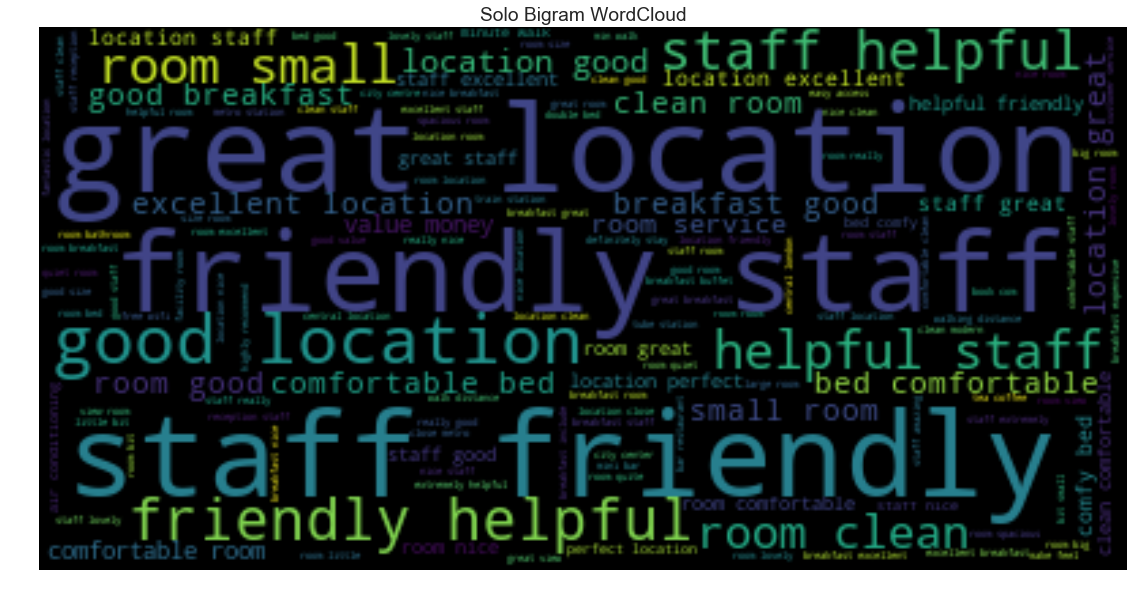

In [23]:
# Ngram
def ngram(n,txt):
    tfidf_vec = TfidfVectorizer(min_df=10, ngram_range=(1, n),stop_words='english',lowercase=True,token_pattern='[a-zA-Z]{3,}',max_features = 5000)
    tfidf_vec.fit(txt)
    tfidf_m=tfidf_vec.transform(txt)
    words_ngram=[w for w in tfidf_vec.get_feature_names() if len(w.split(' '))>n-1]
    idx_ngram=[tfidf_vec.vocabulary_[w] for w in words_ngram]
    dn=dict(zip(words_ngram, np.ravel(tfidf_m.sum(axis=0))[idx_ngram]))
    
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=dn)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off");
# Unigram wordcloud
ngram(2,df_txt_label['Rev_Lemmatized'])
plt.title('Solo Bigram WordCloud');

## Use sklearn LDA Document Topics for Prediction

**Build up the pipeline**

In [25]:
#X_train, X_test, y_train, y_test=train_test_split(df_txt_label['Rev_Lemmatized'],df_txt_label['label_cat'],test_size=0.3,random_state=100)



steps=[('vectorise',CountVectorizer()),
       ('LDA', LDA(n_components=5, random_state=100)),
       ('clf',MultinomialNB())]

res_lda=run_pipeline(steps,X_train,y_train,X_test,y_test);

lda_training_accuracy=res_lda[1]
lda_test_accuracy=res_lda[2]
lda_class_report=res_lda[3]

# # Save model using pickle
pickle.dump(res_lda, open('save/res_lda.sav', 'wb'))
# some time later...
# load the model from disk
#res_lda=pickle.load(open('save/res_lda.sav', 'rb'))


pickle.dump(lda_training_accuracy, open('save/lda_training_accuracy.sav', 'wb'))
pickle.dump(lda_test_accuracy, open('save/lda_test_accuracy.sav', 'wb'))
pickle.dump(lda_class_report, open('save/lda_class_report.sav', 'wb'))




/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Accuracy of training set: 0.52
Accuracy of test set: 0.53

 Classificatio Report:
              precision    recall  f1-score   support

          0       0.68      0.42      0.52     46248
          1       0.48      0.87      0.62     55750
          2       0.00      0.00      0.00     26842

avg / total       0.45      0.53      0.45    128840



**Grid Search Hyperparameters**<br>
This step takes time and computing resources. 

In [ ]:
# steps=[('vectorise',CountVectorizer()),
#        #('transform',TfidfTransformer()),
#        ('LDA', LDA(n_components=5, random_state=100)),
#        ('clf',MultinomialNB())]

# model=run_pipeline(steps,X_train,y_train,X_test,y_test)
# print(model[0].named_steps.keys())

# search_params = dict(#vectorise__stop_words=[None,'english'],
#                   vectorise__binary=[True,False],
#                   vectorise__min_df=[1,5,10],
#                   vectorise__ngram_range=[(1,1),(1,2)],
#                   clf__alpha=[0.01,0.1,1,10]
#                  )

# res_GridSearch_lda=my_grid_search(model,search_params,X_train,y_train,X_test,y_test,nfolds=5,scoring='accuracy')

## Use Gensim LDA Document Topics for Prediction

In [31]:
# Small sample for testing
#df=pd.read_csv('data/htl_rev_lem_label_added.csv').sample(50,random_state=100)
#X_rev=df['Rev_Lemmatized']
#y=df['label_cat']

X_rev=df_txt_label['Rev_Lemmatized']
y=df_txt_label['label_cat']


# Split data into training and test set
itrain, _ = train_test_split(range(df_txt_label.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt_label.shape[0], dtype=np.bool)
mask[itrain] = True

X_train=X_rev[mask]
y_train=y[mask]

X_test=X_rev[~mask]
y_test=y[~mask]


# Prepare NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['hotel','room'])


# # Tokenize and clean sentences to words 
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations



# def process_text(sentences):
#     # Create Corpus
#     txt_tokenized=list(sent_to_words(sentences))
#     # Remove stopwords
#     txt_tokenized = [[w for w in doc if w not in stop_words] for doc in txt_tokenized]
#     return txt_tokenized



# def build_lda(revs,ntopics,passes=15):
#     """Tokenize and clean reviews by process_text, then create dictionary and corpus and build LDA model"""
#     rev_tokenized=process_text(revs)
#     # Create Dictionary-association word to numericID
#     dictionary = gensim.corpora.Dictionary(rev_tokenized )
#     # Term Document Frequency-transform collections of texts to numeric form
#     corpus = [dictionary.doc2bow(txt) for txt in rev_tokenized ]


#     #save dictionary and corpus
#     pickle.dump(corpus, open('corpus.pkl', 'wb'))
#     dictionary.save('dictionary.gensim')

#     #build lda model
#     ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics = ntopics, id2word=dictionary, passes=15,random_state=100)
#     #ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics =ntopics, id2word=dictionary, passes=15,random_state=100) 
#     #Multicore very demanding on memory; can do for ntopics=10 but not 50 +
    
#     #save ldamodel
#     ldamodel.save('model{0}.gensim'.format(ntopics))
#     topics = ldamodel.print_topics(num_words=10)
#     for topic in topics:
#         print('Topics:\n',topic)
    
#     print('num_topic: %d' %ntopics)
    
#     # Compute Perplexity
#     log_perplexity=ldamodel.log_perplexity(corpus)
#     print('\nPerplexity: %.2f' %(log_perplexity))  # a measure of how good the model is. lower the better.

#     # Compute Coherence Score
#     coherence_ldamodel= CoherenceModel(model=ldamodel, texts=rev_tokenized, dictionary=dictionary, coherence='c_v')
#     coherence= coherence_ldamodel.get_coherence()
#     print('\nCoherence Score: %.2f' %coherence)
    
#     return ntopics,log_perplexity,coherence


def extract_listoftuple(ls,nth):
    """extract the nth elements of each tuple in a list of tuples"""
    return [i[nth] for i in ls]


def gensim_lda_feature(doc,dictionary,corpus,num_topics,ldamodel):
    """extract document-topic matrix from gensim lda and convert it into a form ready to be used for prediction """
    
    # Create document-topic-matrix for new documents
    doc_tokenized=process_text(doc)
    doc_bow=[dictionary.doc2bow(d) for d in doc_tokenized]
    dtm=ldamodel.get_document_topics(doc_bow)

    # Save the document-topic-matrix object in a data frame
    df_dtm=pd.DataFrame([i for i in dtm])

    # Fill None in the data frame
    df_dtm_fillna=df_dtm.applymap(lambda x: (0,0) if x is None else x)
    # Extract the topic probability as the element in each cell of df
    dtm_gensimlda=df_dtm_fillna.apply(lambda x: extract_listoftuple(x,1),axis=1)
    dtm_gensimlda.columns=['Topic'+str(i) for i in range(int(num_topics))]
    return dtm_gensimlda.values

# a FunctionTransformer turns a python function into an object that a scikit-learn pipeline can understand
gensim_lda_extractFeature=FunctionTransformer(lambda x: gensim_lda_feature(x,dictionary,corpus,ntopics,lda),validate=False)

In [34]:
ntopics=5
build_lda(X_train,ntopics,passes=15);
    
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
#_=gensim_lda_feature(X_train,dictionary,corpus,ntopic,lda5)

steps=[('gensimLDA',gensim_lda_extractFeature),
       ('clf',MultinomialNB(alpha=0.01))]
res_lda_gsm=run_pipeline(steps,X_train,y_train,X_test,y_test)

lda_gsm_training_accuracy=res_lda_gsm[1]
lda_gsm_test_accuracy=res_lda_gsm[2]
lda_gsm_class_report=res_lda_gsm[3]


# # Save model using pickle
#pickle.dump(model_gensiLDA, open('save/res_lda_gsm.sav', 'wb'))
# some time later...
# load the model from disk
#res_lda_gsm=pickle.load(open('save/res_lda_gsm.sav', 'rb'))



pickle.dump(lda_gsm_training_accuracy, open('save/lda_gsm_training_accuracy.sav', 'wb'))
pickle.dump(lda_gsm_test_accuracy, open('save/lda_gsm_test_accuracy.sav', 'wb'))
pickle.dump(lda_gsm_class_report, open('save/lda_gsm_class_report.sav', 'wb'))

 


# # Grid Search optimal parameters. Time-consuming    
# search_params = dict(clf__alpha=[0.01,0.1,1,10])
# res_Grid_Gensimlda=my_grid_search(model_gensiLDA,search_params,X_train,y_train,X_test,y_test,nfolds=5,scoring='accuracy');

Topics:
 (0, '0.077*"staff" + 0.048*"breakfast" + 0.047*"room" + 0.042*"location" + 0.035*"good" + 0.035*"friendly" + 0.034*"great" + 0.033*"helpful" + 0.022*"excellent" + 0.020*"clean"')
Topics:
 (1, '0.059*"room" + 0.026*"work" + 0.020*"coffee" + 0.016*"night" + 0.016*"water" + 0.015*"air" + 0.013*"wifi" + 0.013*"noise" + 0.012*"tea" + 0.012*"hot"')
Topics:
 (2, '0.031*"close" + 0.030*"station" + 0.027*"location" + 0.026*"walk" + 0.023*"good" + 0.021*"city" + 0.020*"metro" + 0.013*"minute" + 0.013*"great" + 0.012*"nice"')
Topics:
 (3, '0.087*"room" + 0.036*"bed" + 0.026*"bathroom" + 0.025*"small" + 0.020*"location" + 0.020*"good" + 0.015*"shower" + 0.012*"clean" + 0.012*"nice" + 0.012*"pool"')
Topics:
 (4, '0.018*"staff" + 0.018*"stay" + 0.017*"room" + 0.016*"check" + 0.014*"time" + 0.012*"get" + 0.011*"would" + 0.011*"day" + 0.010*"book" + 0.010*"go"')
num_topic: 5

Perplexity: -6.85

Coherence Score: 0.59
Accuracy of training set: 0.48
Accuracy of test set: 0.49

 Classificatio Rep

##  Compare Model Performance

In [86]:
# load the model from disk
bow_training_accuracy=pickle.load(open('save/bow_training_accuracy.sav', 'rb'))
bow_test_training_accuracy=pickle.load(open('save/bow_test_accuracy.sav', 'rb'))
bow_class_report = pickle.load(open('save/bow_class_report.sav', 'rb'))

bow_GridSearch_training_accuracy=pickle.load(open('save/bow_GridSearch_training_accuracy.sav', 'rb'))
bow_GridSearch_test_training_accuracy=pickle.load(open('save/bow_GridSearch_test_accuracy.sav', 'rb'))
bow_GridSearch_class_report = pickle.load(open('save/bow_GridSearch_class_reportt.sav', 'rb'))



tfidf_training_accuracy=pickle.load(open('save/tfidf_training_accuracy.sav', 'rb'))
tfidf_test_training_accuracy=pickle.load(open('save/tfidf_test_accuracy.sav', 'rb'))
tfidf_class_report = pickle.load(open('save/tfidf_class_report.sav', 'rb'))


tfidf_chi_training_accuracy=pickle.load(open('save/tfidf_chi_training_accuracy.sav', 'rb'))
tfidf_test_training_accuracy=pickle.load(open('save/tfidf_chi_test_accuracy.sav', 'rb'))
tfidf_chi_class_report = pickle.load(open('save/tfidf_chi_class_report.sav', 'rb'))



lda_training_accuracy=pickle.load(open('save/lda_training_accuracy.sav', 'rb'))
lda_test_accuracy=pickle.load(open('save/lda_test_accuracy.sav', 'rb'))
lda_class_report = pickle.load(open('save/lda_class_report.sav', 'rb'))



lda_gsm_training_accuracy=pickle.load(open('save/lda_gsm_training_accuracy.sav', 'rb'))
lda_gsm_test_accuracy=pickle.load(open('save/lda_gsm_test_accuracy.sav', 'rb'))
lda_gsm_class_report= pickle.load(open('save/lda_gsm_class_report.sav', 'rb'))

In [89]:
# Accuracy score of the training and test set for each model
model_accuracy={
                'bow':[bow_training_accuracy, bow_test_accuracy],
                'bow_GridSearch': [bow_GridSearch_training_accuracy,bow_GridSearch_test_accuracy],
                'tfidf':[tfidf_training_accuracy,tfidf_test_accuracy],
                'tfidf_chi':[tfidf_chi_training_accuracy,tfidf_chi_test_accuracy],
                'lda':[lda_training_accuracy,lda_test_accuracy],
                'lda_gensim':[lda_gsm_training_accuracy,lda_gsm_test_accuracy]
 
}
model_performance=pd.DataFrame.from_dict(model_accuracy,orient='index')
model_performance.columns=['training_accuracy','test_accuracy']
np.round(model_performance,2).T

,bow,bow_GridSearch,tfidf,tfidf_chi,lda,lda_gensim
training_accuracy,0.62,0.64,0.66,0.62,0.52,0.48
test_accuracy,0.61,0.62,0.62,0.62,0.53,0.49


In [90]:
# Print classification report
print('bow: \n')
print(bow_class_report)

print('bow_GridSearch: \n')
print(bow_GridSearch_class_report)

print('tfidf: \n')
print(tfidf_class_report)

print('tfidf_chi: \n')
print(tfidf_chi_class_report)

print('lda: \n')
print(lda_class_report)

print('lda_gensim: \n')
print(lda_gsm_class_report)




bow: 

             precision    recall  f1-score   support

          0       0.70      0.66      0.68     46248
          1       0.57      0.60      0.59     55750
          2       0.53      0.52      0.53     26842

avg / total       0.61      0.61      0.61    128840

bow_GridSearch: 

             precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.70      0.63     55750
          2       0.60      0.38      0.46     26842

avg / total       0.63      0.62      0.62    128840

tfidf: 

             precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.72      0.64     55750
          2       0.63      0.32      0.43     26842

avg / total       0.63      0.62      0.61    128840

tfidf_chi: 

             precision    recall  f1-score   support

          0       0.73      0.66      0.69     46248
          1       0.56      0.77      0.65